In [155]:
import helpFunctions as hf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import pandas as pd

In [156]:
dirIn = 'data/'

In [157]:
## Example of loading a multi spectral image
multiIm, annotationIm = hf.loadMulti('multispectral_day01.mat' , 'annotation_day01.png', dirIn)

# multiIm is a multi spectral image - the dimensions can be seen by
display(multiIm.shape)

## annotationIm is a binary image with 3 layers
display(annotationIm.shape)

(514, 514, 19)

(514, 514, 3)

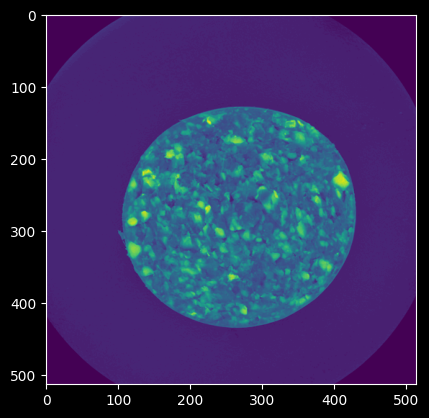

In [158]:
## Show image óf spectral band 7
plt.imshow(multiIm[:,:,6])
plt.show()

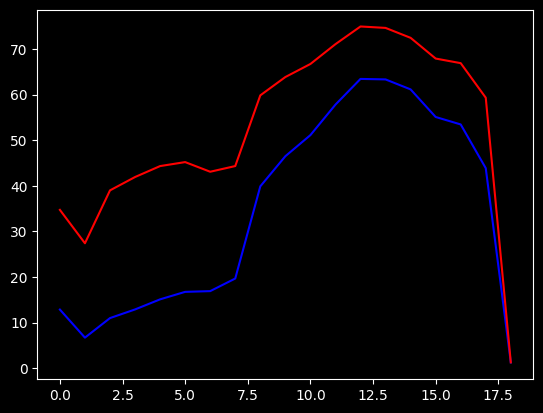

In [159]:
# Example with meat- and fat annotation
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1])
[meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2])

# Plot the mean values for pixels with meat and fat respectively
plt.plot(np.mean(meatPix,0),'b')
plt.plot(np.mean(fatPix,0),'r')
plt.show()

(256, 1)
[[  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  5.]
 [ 19.]
 [ 50.]
 [124.]
 [194.]
 [226.]
 [143.]
 [122.]
 [ 51.]
 [ 24.]
 [  6.]
 [  3.]
 [  1.]
 [  1.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]

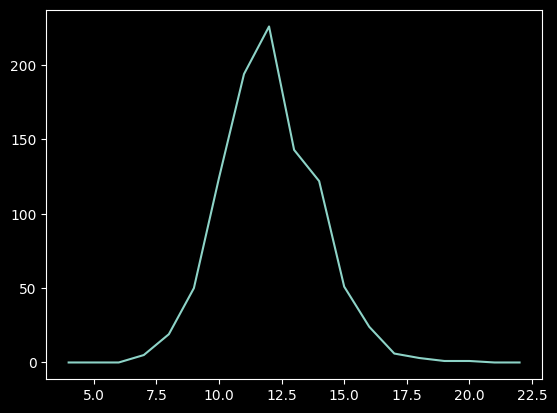

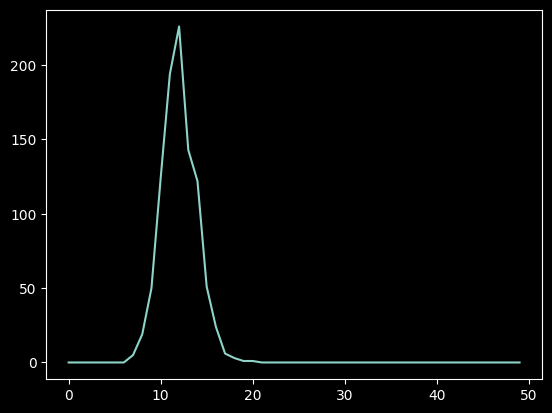

In [160]:
## The function showHistogram makes a histogram that is returned as a vector

# Here is an example - last argument tells the function to plot the histogram for meat and fat
h = hf.showHistograms(multiIm, annotationIm[:,:,2:3], 2, 1)

## The histogram is also in h
# But not truncated like in the plot. If we wnat to avoid plotting all 256 dimensions,
# we can do like below, and only plot the first 50 values

plt.plot(h[0:50:,:])
plt.show()

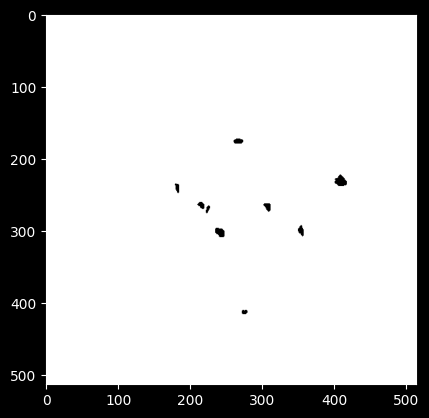

In [161]:
## The function setImagePix produces a colour image
# where the pixel coordinates are given as input

# Load RGB image
imRGB = imread(dirIn + 'color_day01.png')

# Pixel coordinates for the fat annotation
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1])

# Concatenate the pixel coordinates to a matrix
pixId = np.stack((fatR, fatC), axis=1)

# Make the new images
rgbOut = hf.setImagePix(imRGB, pixId)
plt.imshow(rgbOut)
plt.show()

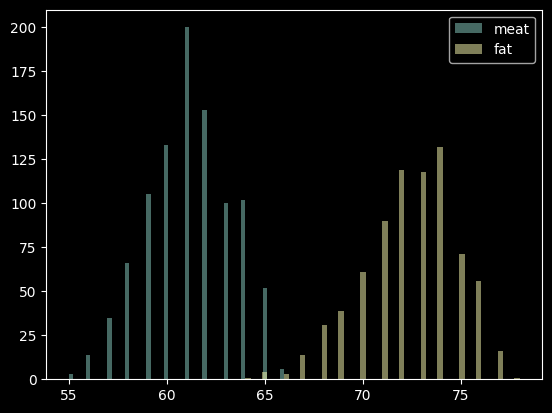

In [162]:
# Band 15 histogram
l = 14
plt.hist(meatPix[:, l], bins=50, alpha=0.5, label="meat")
plt.hist(fatPix[:, l],  bins=50, alpha=0.5, label="fat")
plt.legend()
plt.show()

In [163]:
def train_thr_model(fatPix, meatPix):
    Nf, Nm = fatPix.shape[0], meatPix.shape[0]
    err = np.zeros(19)
    thr = np.zeros(19)

    for l in range(19):
        mu_f = np.mean(fatPix[:, l])
        mu_m = np.mean(meatPix[:, l])
        thr[l] = 0.5 * (mu_f + mu_m)

        fat_wrong  = np.sum(fatPix[:, l]  <  thr[l])
        meat_wrong = np.sum(meatPix[:, l] >= thr[l])
        err[l] = (fat_wrong + meat_wrong) / (Nf + Nm)

    best_l = int(np.argmin(err))
    best_band = best_l + 1
    thr_best = thr[best_l]
    return best_l, best_band, thr_best

def eval_thr_model(fatPix, meatPix, best_l, thr_best):
    Nf, Nm = fatPix.shape[0], meatPix.shape[0]
    fat_wrong  = np.sum(fatPix[:, best_l]  <  thr_best)
    meat_wrong = np.sum(meatPix[:, best_l] >= thr_best)
    return (fat_wrong + meat_wrong) / (Nf + Nm)

best_l, best_band, thr_best = train_thr_model(fatPix, meatPix)
err_best = eval_thr_model(fatPix, meatPix, best_l, thr_best)

best_band, thr_best, err_best


(14, np.float64(68.9655142758858), np.float64(0.00463768115942029))

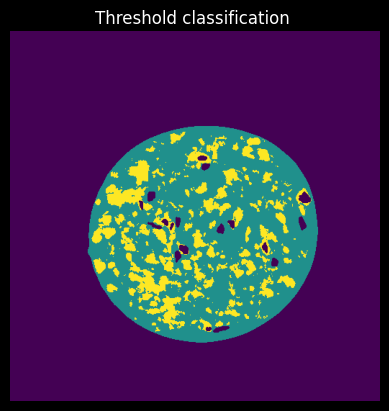

In [164]:
salami_an = annotationIm[:, :, 0].astype(bool)

cls = np.zeros(multiIm.shape[:2], dtype=np.uint8)
cls[salami_an] = 1
cls[salami_an & (multiIm[:, :, best_l] >= thr_best)] = 2

plt.figure()
plt.imshow(cls)
plt.title(f"Threshold classification ")
plt.axis("off")
plt.show()

In [165]:
# single-band threshold model proportion
salami_single = cls[salami_an]
n_meat_LDA_prior = len(salami_single[salami_single == 1])
n_fat_LDA_prior = len(salami_single[salami_single == 2])
print(n_fat_LDA_prior / (n_fat_LDA_prior + n_meat_LDA_prior))

0.23824582742077166


In [166]:
def train_lda(fatPix, meatPix):
    #Number of annotated fat and meat pixels
    Nf = fatPix.shape[0]
    Nm = meatPix.shape[0]

    # Means
    mu_f = np.mean(fatPix, axis=0)
    mu_m = np.mean(meatPix, axis=0)

    # Covariance matrices for fat and meat
    Sigma_f = np.cov(fatPix, rowvar=False, ddof=1)
    Sigma_m = np.cov(meatPix, rowvar=False, ddof=1)
    # Pooled covariance (LDA assumption)
    Sigma = ((Nf-1)*Sigma_f + (Nm-1)*Sigma_m) / ((Nf-1)+(Nm-1))
    Sigma_inv = np.linalg.pinv(Sigma)

    # rewrite (S_f - S_m) to x^T*w+c
    w = Sigma_inv @ (mu_f - mu_m)
    c = -0.5 * (mu_f @ Sigma_inv @ mu_f - mu_m @ Sigma_inv @ mu_m)
    return Sigma, w, c

def eval_lda(fatPix, meatPix, w, c):
    Nf, Nm = fatPix.shape[0], meatPix.shape[0]
    fat_wrong  = np.sum((fatPix  @ w + c) < 0)
    meat_wrong = np.sum((meatPix @ w + c) >= 0)
    return (fat_wrong + meat_wrong) / (Nf + Nm)

Sigma,w,c = train_lda(fatPix, meatPix)

err_lda = eval_lda(fatPix, meatPix, w, c)

err_lda

np.float64(0.005797101449275362)

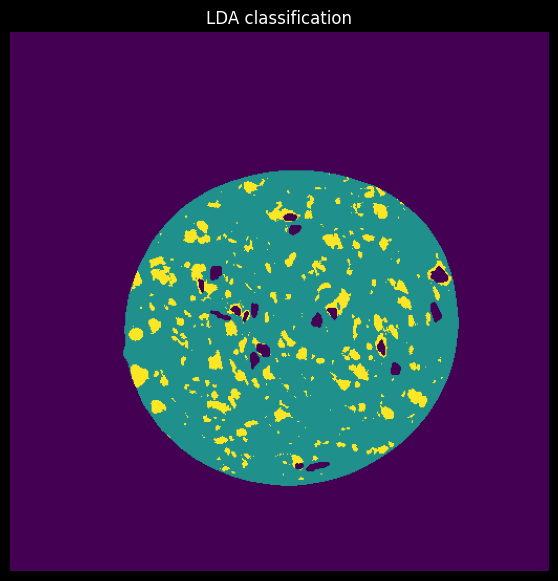

In [167]:
# Extract only salami pixels as vector
X_salami = multiIm[salami_an, :].astype(np.float64)

s_salami = X_salami @ w + c

cls_lda = np.zeros(multiIm.shape[:2], dtype=np.uint8)
cls_lda[salami_an] = 1
cls_lda[salami_an] = np.where(s_salami >= 0, 2, 1)

plt.figure(figsize=(7, 7))
plt.imshow(cls_lda)
plt.title("LDA classification")
plt.axis("off")
plt.show()

In [168]:
# multispectral LDA proportion
n_meat_LDA_prior = np.sum(cls_lda[salami_an] == 1)
n_fat_LDA_prior = np.sum(cls_lda[salami_an] == 2)
n_fat_LDA_prior / (n_fat_LDA_prior + n_meat_LDA_prior)

np.float64(0.12456247043719171)

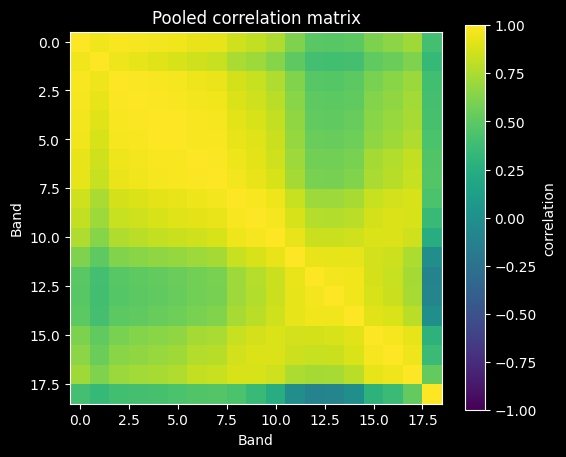

In [169]:
# Plot of correlation matrix
D = np.sqrt(np.diag(Sigma))
Corr = Sigma / np.outer(D, D)

plt.figure(figsize=(6, 5))
plt.imshow(Corr, vmin=-1, vmax=1)
plt.colorbar(label="correlation")
plt.title("Pooled correlation matrix")
plt.xlabel("Band")
plt.ylabel("Band")
plt.show()

In [170]:
# helper for loading days
def load_day(d):
    ms_file = f"multispectral_day{d:02d}.mat"
    an_file = f"annotation_day{d:02d}.png"
    return hf.loadMulti(ms_file, an_file, dirIn)

In [171]:
test_days = [6, 13, 20, 28]

results = []

# computes errors of threshold and LDA models trained on day 1 data
for d in test_days:
    multiIm_d, annotationIm_d = load_day(d)

    # extract evaluation pixels
    fatPix_d,  _, _ = hf.getPix(multiIm_d, annotationIm_d[:, :, 1])
    meatPix_d, _, _ = hf.getPix(multiIm_d, annotationIm_d[:, :, 2])

    Nf_d = fatPix_d.shape[0]
    Nm_d = meatPix_d.shape[0]

    # Threshold error
    err_thr_d = eval_thr_model(fatPix_d, meatPix_d, best_l, thr_best)

    # LDA error
    err_lda_d = eval_lda(fatPix_d, meatPix_d,w,c)

    results.append({"day": d, "thr_err": err_thr_d, "lda_err": err_lda_d})


df = pd.DataFrame(results)
print(df.to_string(index=False))

 day  thr_err  lda_err
   6 0.123195 0.021174
  13 0.123724 0.085886
  20 0.241765 0.138824
  28 0.182432 0.059846


In [172]:
days = [1, 6, 13, 20, 28]
n = len(days)

results_all_days = []

# trains models for each day and tests on remaining
for i, d_train in enumerate(days):
    #load data
    multi_train, ann_train = load_day(d_train)
    fat_train, _, _  = hf.getPix(multi_train, ann_train[:, :, 1])
    meat_train, _, _ = hf.getPix(multi_train, ann_train[:, :, 2])

    # train both models on this day
    best_l, _, thr_best = train_thr_model(fat_train, meat_train)
    _, w, c = train_lda(fat_train, meat_train)

    # test on other days
    for j, d_test in enumerate(days):
        if d_test == d_train:
            continue

        multi_test, ann_test = load_day(d_test)
        fat_test, _, _  = hf.getPix(multi_test, ann_test[:, :, 1])
        meat_test, _, _ = hf.getPix(multi_test, ann_test[:, :, 2])

        thr_err = eval_thr_model(fat_test, meat_test, best_l, thr_best)
        lda_err = eval_lda(fat_test, meat_test, w, c)

        results_all_days.append({"train": d_train, "test": d_test, "thr_err": thr_err, "lda_err": lda_err})

# Print
df = pd.DataFrame(results_all_days)
print(df.to_string(index=False))


 train  test  thr_err  lda_err
     1     6 0.123195 0.021174
     1    13 0.123724 0.085886
     1    20 0.241765 0.138824
     1    28 0.182432 0.059846
     6     1 0.010435 0.023188
     6    13 0.077477 0.015616
     6    20 0.152353 0.042353
     6    28 0.121622 0.042471
    13     1 0.012754 0.011014
    13     6 0.004331 0.001444
    13    20 0.065882 0.020000
    13    28 0.052606 0.014961
    20     1 0.005217 0.011014
    20     6 0.003369 0.011068
    20    13 0.025826 0.003604
    20    28 0.040541 0.049228
    28     1 0.001159 0.006957
    28     6 0.002887 0.023099
    28    13 0.026426 0.010210
    28    20 0.027647 0.001176


In [173]:
#Train LDA without prior knowledge
Sigma,w,c = train_lda(fatPix, meatPix)

# Prior knowledge
pf=0.3
pm=0.7
log_prior=np.log(pf/pm)
c_w_prior = c + log_prior

err_lda = eval_lda(fatPix, meatPix, w, c)
err_lda_w_prior = eval_lda(fatPix, meatPix, w, c_w_prior)

err_lda_w_prior, err_lda

(np.float64(0.005797101449275362), np.float64(0.005797101449275362))

In [174]:
test_days = [6, 13, 20, 28]

results = []

# computes errors of threshold and LDA models trained on day 1 data
for d in test_days:
    multiIm_d, annotationIm_d = load_day(d)

    # extract evaluation pixels
    fatPix_d,  _, _ = hf.getPix(multiIm_d, annotationIm_d[:, :, 1])
    meatPix_d, _, _ = hf.getPix(multiIm_d, annotationIm_d[:, :, 2])

    Nf_d = fatPix_d.shape[0]
    Nm_d = meatPix_d.shape[0]

    # Threshold error
    err_thr_d = eval_thr_model(fatPix_d, meatPix_d, best_l, thr_best)

    # LDA error
    err_lda_d = eval_lda(fatPix_d, meatPix_d,w,c)

    # LDA with priors
    err_lda_w_prior_d = eval_lda(fatPix_d, meatPix_d,w,c_w_prior)

    results.append({"day": d, "thr_err": err_thr_d, "lda_err": err_lda_d, "lda_err_w_prior": err_lda_w_prior_d})


df = pd.DataFrame(results)
print(df.to_string(index=False))

 day  thr_err  lda_err  lda_err_w_prior
   6 0.002887 0.021174         0.021655
  13 0.026426 0.085886         0.087688
  20 0.027647 0.138824         0.140000
  28 0.039093 0.059846         0.063224


In [175]:
days = [1, 6, 13, 20, 28]
n = len(days)

results_all_days = []

# trains models for each day and tests on remaining
for i, d_train in enumerate(days):
    #load data
    multi_train, ann_train = load_day(d_train)
    fat_train, _, _  = hf.getPix(multi_train, ann_train[:, :, 1])
    meat_train, _, _ = hf.getPix(multi_train, ann_train[:, :, 2])

    # train both models on this day
    best_l, _, thr_best = train_thr_model(fat_train, meat_train)
    _, w, c = train_lda(fat_train, meat_train)
    c_w_prior_d = c + log_prior

    # test on other days
    for j, d_test in enumerate(days):
        if d_test == d_train:
            continue

        multi_test, ann_test = load_day(d_test)
        fat_test, _, _  = hf.getPix(multi_test, ann_test[:, :, 1])
        meat_test, _, _ = hf.getPix(multi_test, ann_test[:, :, 2])

        thr_err = eval_thr_model(fat_test, meat_test, best_l, thr_best)
        lda_err = eval_lda(fat_test, meat_test, w, c)
        lda_w_prior_err = eval_lda(fat_test, meat_test, w, c_w_prior_d)

        results_all_days.append({"train": d_train, "test": d_test, "thr_err": thr_err, "lda_err": lda_err, "lda_w_prior_err": lda_w_prior_err})

# Print
df = pd.DataFrame(results_all_days)
print(df.to_string(index=False))


 train  test  thr_err  lda_err  lda_w_prior_err
     1     6 0.123195 0.021174         0.021655
     1    13 0.123724 0.085886         0.087688
     1    20 0.241765 0.138824         0.140000
     1    28 0.182432 0.059846         0.063224
     6     1 0.010435 0.023188         0.024348
     6    13 0.077477 0.015616         0.016817
     6    20 0.152353 0.042353         0.045882
     6    28 0.121622 0.042471         0.045367
    13     1 0.012754 0.011014         0.012174
    13     6 0.004331 0.001444         0.001925
    13    20 0.065882 0.020000         0.027059
    13    28 0.052606 0.014961         0.018340
    20     1 0.005217 0.011014         0.011014
    20     6 0.003369 0.011068         0.008181
    20    13 0.025826 0.003604         0.003604
    20    28 0.040541 0.049228         0.051641
    28     1 0.001159 0.006957         0.005797
    28     6 0.002887 0.023099         0.017806
    28    13 0.026426 0.010210         0.007808
    28    20 0.027647 0.001176         0

In [177]:
# Extract only salami pixels as vector
X_salami = multiIm[salami_an, :].astype(np.float64)

s_salami = X_salami @ w + c_w_prior_d

cls_lda = np.zeros(multiIm.shape[:2], dtype=np.uint8)
cls_lda[salami_an] = 1
cls_lda[salami_an] = np.where(s_salami >= 0, 2, 1)

# LDA with prior proportion
n_meat_LDA_prior = np.sum(cls_lda[salami_an] == 1)
n_fat_LDA_prior = np.sum(cls_lda[salami_an] == 2)
n_roi = np.sum(salami_an)
n_fat_LDA_prior / n_roi

np.float64(0.2791404824650314)